<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_navier_stokes/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.galerkin import DGMNet
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.galerkin import DGMNet
import numbers
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import time
import logging
from pynverse import inversefunc
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.11.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Thu Dec  1 21:44:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   54C    P8    37W / 350W |    349MiB / 12288MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Navier-Stokes equation
$$
\begin{cases}
  \displaystyle
  \partial_t u_i(t,x) + \frac{\nu}{2} \Delta u_i(t,x) = \partial_{1_i} p(t,x) + \sum\limits_{j=0}^{d-1} u_j(t,x) \partial_{1_j} u_i(t,x), \quad i = 0,\ldots , d-1,
  \\
u_i(T,x) = \phi_i (x),
  \\
  \displaystyle
  \Delta u_{-1}(t, x) = -\sum\limits_{i,j=0}^{d-1} \partial_{1_j} u_i(t,x) \partial_{1_i} u_j(t,x),
   \\
\sum\limits_{i = 0}^{d - 1} \partial_{1_i} u_i(t, x) = 0, \quad (t,x) = (t,x_1, \ldots, x_d) \in [0,T] \times \mathbb{R}^d.
\end{cases}
$$

## 2-dimensional Taylor-Green vortex, T = .25, nu = 2
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = - \cos(x_1) \sin(x_2) e^{-\nu (T - t)},
  \\
  u_2(t, x) = \sin(x_1) \cos(x_2) e^{-\nu (T - t)},
  \\
  \displaystyle
  u_0(t, x) = -\frac{1}{4} \left(\cos(2x_1) + \cos(2x_2)\right) e^{-2\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2) \in [0,2\pi]^2$.

In [4]:
T, nu = .25, 2

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
        [2, 0],  # for Laplacian
        [0, 2],
        [2, 0],
        [0, 2],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
        # Laplacian
        f += nu / 2 * (y[2 * dim + dim * dim + dim * coordinate + j])
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

def boundary_fun(tx, coordinate):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### without boundary

In [5]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-214406-taylor_green_2d
Epoch 0 with loss 0.3043270409107208
Epoch 500 with loss 0.040867533534765244
Epoch 1000 with loss 0.019656455144286156
Epoch 1500 with loss 0.012412120588123798
Epoch 2000 with loss 0.008362386375665665
Epoch 2500 with loss 0.005044164601713419
Epoch 3000 with loss 0.002795727225020528
Epoch 3500 with loss 0.0019165088888257742
Epoch 4000 with loss 0.0015609327238053083
Epoch 4500 with loss 0.0014259821036830544
Epoch 5000 with loss 0.0008224225603044033
Epoch 5500 with loss 0.0006808182806707919
Epoch 6000 with loss 0.0025400526355952024
Epoch 6500 with loss 0.0007891588611528277
Epoch 7000 with loss 0.0009599835029803216
Epoch 7500 with loss 0.0007467587129212916
Epoch 8000 with loss 0.0010915236780419946
Epoch 8500 with loss 0.00034548903931863606
Epoch 9000 with loss 0.0006153204594738781
Epoch 9500 with loss 0.000384280807338655
Epoch 10000 with loss 0.0004880135238636285
Epoch 1

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 8.00E-01 & 7.79E-01 & 7.57E-01 & 7.36E-01 & 7.15E-01 & 6.94E-01 & 6.73E-01 & 6.52E-01 & 6.31E-01 & 6.11E-01 & --- \\
$\hat{e}_1(t_k)$
& 4.55E-01 & 3.81E-01 & 3.11E-01 & 2.46E-01 & 1.87E-01 & 1.35E-01 & 8.92E-02 & 5.19E-02 & 2.39E-02 & 6.16E-03 & --- \\
$\hat{e}(t_k)$
& 8.67E-01 & 8.33E-01 & 8.00E-01 & 7.68E-01 & 7.38E-01 & 7.09E-01 & 6.82E-01 & 6.56E-01 & 6.33E-01 & 6.11E-01 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.01E+00 & 9.20E-01 & 8.35E-01 & 7.57E-01 & 6.88E-01 & 6.26E-01 & 5.73E-01 & 5.29E-01 & 4.94E-01 & 4.67E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 7.15E-01 & 6.48E-01 & 5.85E-01 & 5.27E-01 & 4.73E-01 & 4.24E-01 & 3.79E-01 & 3.41E-01 & 3.09E-01 & 2.85E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.21E-02 & 1.95E-02 & 1.88E-02 & 2.01E-02 & 2.29E-02 & 2.6

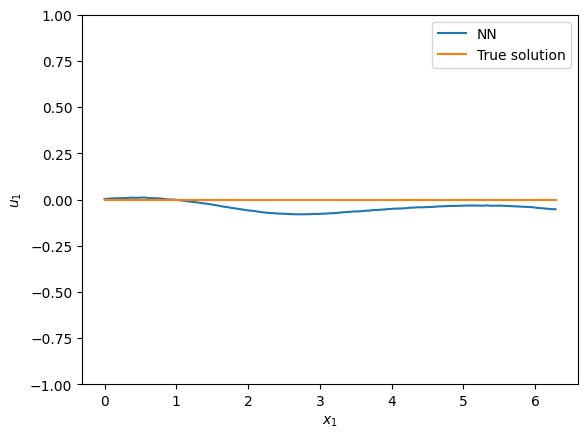

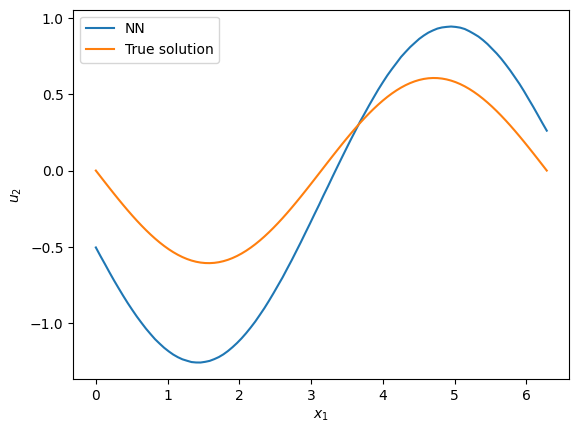

In [6]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

### with boundary

In [7]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
    boundary_fun=boundary_fun,
    overtrain_rate=.0,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-222300-taylor_green_2d
Epoch 0 with loss 0.4430675506591797
Epoch 500 with loss 0.04437808692455292
Epoch 1000 with loss 0.02208627387881279
Epoch 1500 with loss 0.013971281237900257
Epoch 2000 with loss 0.01128695160150528
Epoch 2500 with loss 0.009253391996026039
Epoch 3000 with loss 0.005532004404813051
Epoch 3500 with loss 0.004072746727615595
Epoch 4000 with loss 0.0036441884003579617
Epoch 4500 with loss 0.003620501607656479
Epoch 5000 with loss 0.0021610127296298742
Epoch 5500 with loss 0.0033326561097055674
Epoch 6000 with loss 0.0015168554382398725
Epoch 6500 with loss 0.0014507090672850609
Epoch 7000 with loss 0.0018507157219573855
Epoch 7500 with loss 0.0010994051117449999
Epoch 8000 with loss 0.0010362261673435569
Epoch 8500 with loss 0.0007545578991994262
Epoch 9000 with loss 0.0007529332069680095
Epoch 9500 with loss 0.0008737088646739721
Epoch 10000 with loss 0.0010409317910671234
Epoch 10500 

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.21E+00 & 2.11E+00 & 2.01E+00 & 1.91E+00 & 1.81E+00 & 1.72E+00 & 1.62E+00 & 1.52E+00 & 1.43E+00 & 1.34E+00 & --- \\
$\hat{e}_1(t_k)$
& 1.40E-01 & 1.21E-01 & 1.01E-01 & 8.25E-02 & 6.42E-02 & 4.70E-02 & 3.16E-02 & 1.85E-02 & 8.29E-03 & 1.90E-03 & --- \\
$\hat{e}(t_k)$
& 2.21E+00 & 2.11E+00 & 2.01E+00 & 1.91E+00 & 1.81E+00 & 1.72E+00 & 1.62E+00 & 1.52E+00 & 1.43E+00 & 1.34E+00 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.03E+00 & 9.49E-01 & 8.74E-01 & 8.05E-01 & 7.42E-01 & 6.84E-01 & 6.33E-01 & 5.87E-01 & 5.47E-01 & 5.12E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 8.07E-01 & 7.63E-01 & 7.20E-01 & 6.80E-01 & 6.42E-01 & 6.07E-01 & 5.73E-01 & 5.43E-01 & 5.15E-01 & 4.90E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.56E-02 & 2.28E-02 & 2.22E-02 & 2.32E-02 & 2.53E-02 & 2.8

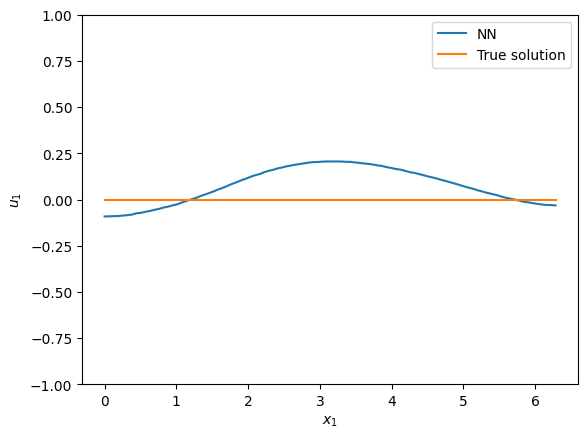

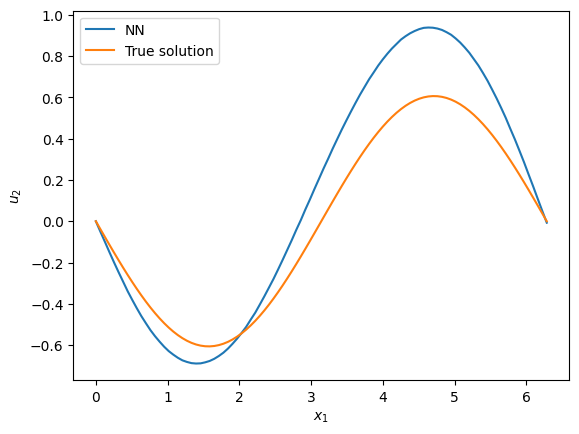

In [8]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

## 2-dimensional Taylor-Green vortex, T = .25, nu = 2 on smaller domain
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = - \cos(x_1) \sin(x_2) e^{-\nu (T - t)},
  \\
  u_2(t, x) = \sin(x_1) \cos(x_2) e^{-\nu (T - t)},
  \\
  \displaystyle
  u_0(t, x) = -\frac{1}{4} \left(\cos(2x_1) + \cos(2x_2)\right) e^{-2\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2) \in [0,1]^2$.

In [9]:
T, nu = .25, 2

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
        [2, 0],  # for Laplacian
        [0, 2],
        [2, 0],
        [0, 2],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
        # Laplacian
        f += nu / 2 * (y[2 * dim + dim * dim + dim * coordinate + j])
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

def boundary_fun(tx, coordinate):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 1

### without boundary

In [10]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-230313-taylor_green_2d
Epoch 0 with loss 0.3408336937427521
Epoch 500 with loss 0.0010709649650380015
Epoch 1000 with loss 0.00039136101258918643
Epoch 1500 with loss 0.00021721118537243456
Epoch 2000 with loss 0.0001376164727844298
Epoch 2500 with loss 0.00010451307753100991
Epoch 3000 with loss 0.00022868302767165005
Epoch 3500 with loss 6.85762133798562e-05
Epoch 4000 with loss 5.449229502119124e-05
Epoch 4500 with loss 8.08190816314891e-05
Epoch 5000 with loss 4.529957004706375e-05
Epoch 5500 with loss 3.201944491593167e-05
Epoch 6000 with loss 6.293044134508818e-05
Epoch 6500 with loss 4.4290234654909e-05
Epoch 7000 with loss 9.785660950001329e-05
Epoch 7500 with loss 0.00012689412687905133
Epoch 8000 with loss 2.567010778875556e-05
Epoch 8500 with loss 1.450540639780229e-05
Epoch 9000 with loss 2.2107691620476544e-05
Epoch 9500 with loss 9.861584658210631e-06
Epoch 10000 with loss 1.0303971976100001e-0

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 1.48E-01 & 1.33E-01 & 1.33E-01 & 1.35E-01 & 1.36E-01 & 1.38E-01 & 1.39E-01 & 1.41E-01 & 1.42E-01 & 1.44E-01 & --- \\
$\hat{e}_1(t_k)$
& 9.81E-02 & 8.38E-02 & 7.00E-02 & 5.66E-02 & 4.40E-02 & 3.23E-02 & 2.19E-02 & 1.31E-02 & 6.21E-03 & 1.69E-03 & --- \\
$\hat{e}(t_k)$
& 2.15E-01 & 2.02E-01 & 1.91E-01 & 1.79E-01 & 1.68E-01 & 1.58E-01 & 1.50E-01 & 1.45E-01 & 1.42E-01 & 1.44E-01 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 9.71E-01 & 8.94E-01 & 8.20E-01 & 7.50E-01 & 6.84E-01 & 6.22E-01 & 5.63E-01 & 5.09E-01 & 4.59E-01 & 4.15E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 4.46E-01 & 3.98E-01 & 3.54E-01 & 3.16E-01 & 2.84E-01 & 2.60E-01 & 2.43E-01 & 2.35E-01 & 2.35E-01 & 2.43E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 8.18E-04 & 7.89E-04 & 7.78E-04 & 7.79E-04 & 7.87E-04 & 8.0

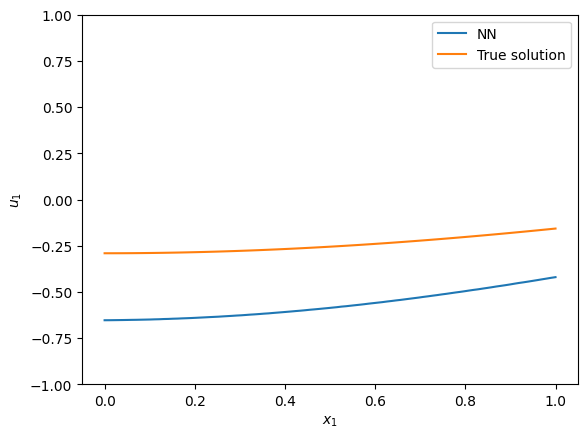

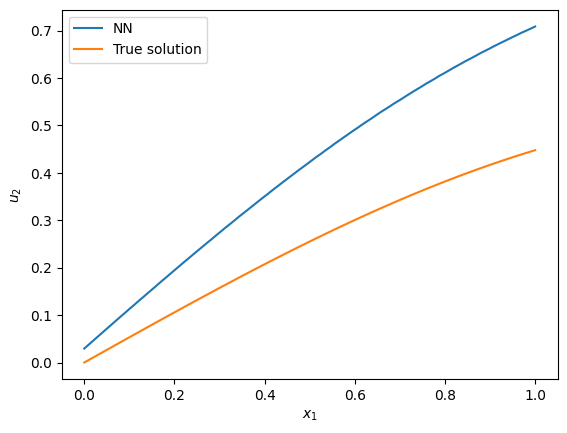

In [11]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

### with boundary

In [12]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
    boundary_fun=boundary_fun,
    overtrain_rate=.0,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-234213-taylor_green_2d
Epoch 0 with loss 0.44750458002090454
Epoch 500 with loss 0.002782892668619752
Epoch 1000 with loss 0.0012584985233843327
Epoch 1500 with loss 0.00038679747376590967
Epoch 2000 with loss 0.00024317484349012375
Epoch 2500 with loss 0.0001924595853779465
Epoch 3000 with loss 0.0007300645229406655
Epoch 3500 with loss 9.556658915244043e-05
Epoch 4000 with loss 5.718684406019747e-05
Epoch 4500 with loss 0.0010299242567270994
Epoch 5000 with loss 0.00018624725635163486
Epoch 5500 with loss 5.280317418510094e-05
Epoch 6000 with loss 5.4308293329086155e-05
Epoch 6500 with loss 4.1967694414779544e-05
Epoch 7000 with loss 2.1275041945045814e-05
Epoch 7500 with loss 0.00014184831525199115
Epoch 8000 with loss 2.2481215637526475e-05
Epoch 8500 with loss 0.0005824065301567316
Epoch 9000 with loss 1.3813735677103978e-05
Epoch 9500 with loss 1.2857293768320233e-05
Epoch 10000 with loss 2.17332781176

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.05E-03 & 1.85E-03 & 2.46E-03 & 3.31E-03 & 4.47E-03 & 6.01E-03 & 8.06E-03 & 1.07E-02 & 1.44E-02 & 1.95E-02 & --- \\
$\hat{e}_1(t_k)$
& 1.03E-04 & 7.93E-05 & 6.25E-05 & 5.07E-05 & 4.29E-05 & 3.81E-05 & 3.58E-05 & 3.55E-05 & 3.70E-05 & 4.01E-05 & --- \\
$\hat{e}(t_k)$
& 2.15E-03 & 1.86E-03 & 2.47E-03 & 3.32E-03 & 4.47E-03 & 6.01E-03 & 8.06E-03 & 1.07E-02 & 1.44E-02 & 1.95E-02 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 6.77E-02 & 7.48E-02 & 8.56E-02 & 9.85E-02 & 1.13E-01 & 1.27E-01 & 1.43E-01 & 1.58E-01 & 1.73E-01 & 1.88E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 1.40E-01 & 1.25E-01 & 1.12E-01 & 1.02E-01 & 9.63E-02 & 9.42E-02 & 9.62E-02 & 1.02E-01 & 1.11E-01 & 1.21E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.83E-03 & 2.95E-03 & 3.05E-03 & 3.12E-03 & 3.17E-03 & 3.2

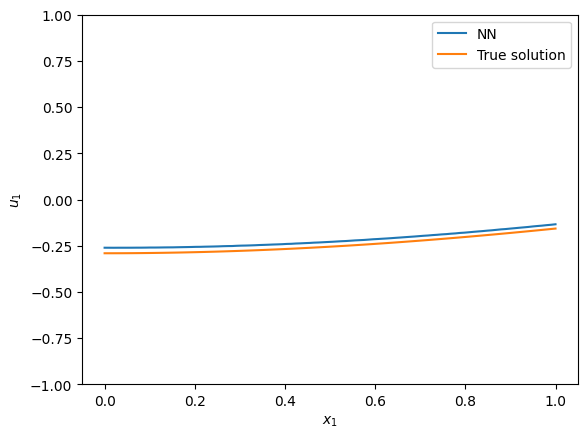

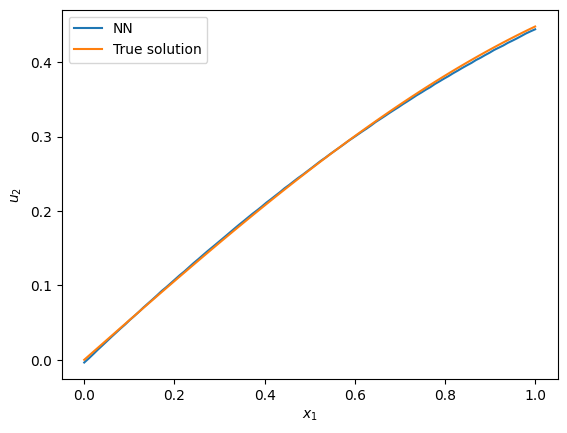

In [13]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))